# 06 - Embedding Experiments

Experimentos com os embeddings de nós gerados pelo modelo GNN, explorando
propriedades estruturais da rede e relações entre embeddings e métricas de grafo.

In [28]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch

plt.style.use("default")

# Caminhos ABSOLUTOS para o ambiente atual
DATA_PATH = Path("/workspace/data/collaboration.edgelist.txt")
EMBEDDINGS_PATH = Path("/workspace/results/node_embeddings.pt")

DATA_DIR = DATA_PATH.parent
PROJECT_DIR = DATA_DIR.parent
RESULTS_DIR = PROJECT_DIR / "results"
FIG_DIR = RESULTS_DIR / "figures"

RESULTS_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR:", DATA_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("FIG_DIR:", FIG_DIR)
print("DATA_PATH:", DATA_PATH, "| exists=", DATA_PATH.exists())
print("EMBEDDINGS_PATH:", EMBEDDINGS_PATH, "| exists=", EMBEDDINGS_PATH.exists())

PROJECT_DIR: /workspace
DATA_DIR: /workspace/data
RESULTS_DIR: /workspace/results
FIG_DIR: /workspace/results/figures
DATA_PATH: /workspace/data/collaboration.edgelist.txt | exists= True
EMBEDDINGS_PATH: /workspace/results/node_embeddings.pt | exists= True


## 1. Carregar grafo de colaboração

Carregamos a edgelist `collaboration.edgelist.txt` (duas primeiras colunas como
endpoints) e construímos um grafo não-direcionado em NetworkX.

In [29]:
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Edge list not found at: {DATA_PATH}")

# Lê as duas primeiras colunas como source/target
df_edges = pd.read_csv(
    DATA_PATH,
    sep=r"\s+",  # separador por espaço/tab
    header=None,
    usecols=[0, 1],
    names=["source", "target"],
)

print("Primeiras linhas da edge list:")
display(df_edges.head())

# Constrói o grafo não-direcionado
G = nx.Graph()
G.add_edges_from(zip(df_edges["source"], df_edges["target"]))

print("=== GRAPH OVERVIEW ===")
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density:.6f}")

try:
    is_connected = nx.is_connected(G)
except nx.NetworkXError:
    is_connected = False

num_components = nx.number_connected_components(G)
print(f"Connected: {is_connected}")
print(f"Number of connected components: {num_components}")

# LCC (para alguns experimentos, se necessário)
components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_cc = components[0]
size_lcc = len(largest_cc)
print(f"LCC size: {size_lcc} nodes ({size_lcc / num_nodes:.2%} of all nodes)")

Primeiras linhas da edge list:


,source,target
0,0,1680
1,0,6918
2,0,19642
3,1,4131
4,1,5645


=== GRAPH OVERVIEW ===
Number of nodes: 23133
Number of edges: 93439
Density: 0.000349
Connected: False
Number of connected components: 567
LCC size: 21363 nodes (92.35% of all nodes)


## 2. Carregar embeddings de nós (`node_embeddings.pt`)

Suportamos dois formatos comuns:
1. Tensor direto salvo via `torch.save(tensor)`
2. Dicionário com chaves como `"emb"`, `"embeddings"` ou `"node_embeddings"`, e
   opcionalmente `"node_ids"`.

In [30]:
if not EMBEDDINGS_PATH.exists():
    raise FileNotFoundError(f"Embeddings file not found at: {EMBEDDINGS_PATH}")

obj = torch.load(EMBEDDINGS_PATH, map_location="cpu")

emb_tensor = None
node_ids = None

if torch.is_tensor(obj):
    emb_tensor = obj
elif isinstance(obj, dict):
    # tenta chaves mais prováveis primeiro
    for key in ["emb", "embeddings", "node_embeddings"]:
        if key in obj and torch.is_tensor(obj[key]):
            emb_tensor = obj[key]
            break
    # se ainda não encontrou, tenta qualquer tensor no dict
    if emb_tensor is None:
        for v in obj.values():
            if torch.is_tensor(v):
                emb_tensor = v
                break
    # captura node_ids se existir
    if "node_ids" in obj:
        node_ids = list(obj["node_ids"])
else:
    raise ValueError("Formato de embeddings não reconhecido em node_embeddings.pt")

if emb_tensor is None:
    raise ValueError("Não foi possível encontrar tensor de embeddings em node_embeddings.pt")

emb_tensor = emb_tensor.detach().cpu()
num_nodes_emb, emb_dim = emb_tensor.shape
print(f"Embeddings shape: {emb_tensor.shape} (nodes x dim)")

if node_ids is not None:
    print("Número de node_ids:", len(node_ids))
else:
    print("Nenhuma lista explícita de node_ids encontrada; será usada uma associação heurística.")

Embeddings shape: torch.Size([23133, 64]) (nodes x dim)
Nenhuma lista explícita de node_ids encontrada; será usada uma associação heurística.


## 3. DataFrame de embeddings e alinhamento com nós do grafo

- Se `node_ids` existir, usamos diretamente.
- Caso contrário, tentamos alinhar com `sorted(G.nodes())`. Se o número de nós
  não bater com o número de linhas dos embeddings, usamos índices simples
  `0..N-1` na coluna `node`.

In [31]:
emb_np = emb_tensor.numpy()

if node_ids is not None:
    if len(node_ids) != num_nodes_emb:
        raise ValueError("Tamanho de node_ids diferente do número de linhas dos embeddings.")
    node_index = node_ids
else:
    sorted_nodes = sorted(G.nodes())
    if len(sorted_nodes) == num_nodes_emb:
        node_index = sorted_nodes
    else:
        print("[AVISO] Número de embeddings difere do número de nós do grafo.")
        print("Usando índices 0..N-1 em 'node'.")
        node_index = list(range(num_nodes_emb))

emb_cols = [f"dim_{i}" for i in range(emb_dim)]
df_emb = pd.DataFrame(emb_np, columns=emb_cols)
df_emb.insert(0, "node", node_index)

# Norma L2 de cada vetor de embedding
emb_norms = np.linalg.norm(emb_np, axis=1)
df_emb["norm"] = emb_norms

print("DataFrame de embeddings:")
display(df_emb.head())
print("\nResumo das normas:")
display(df_emb["norm"].describe())

# Salva embeddings brutos
out_raw = RESULTS_DIR / "06_node_embeddings_raw.csv"
df_emb.to_csv(out_raw, index=False)
print("Embeddings salvos em:", out_raw)

DataFrame de embeddings:


,node,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,norm
0,0,0.000000,0.011541,0.039987,0.0,0.0,0.004841,0.000000,0.016014,0.052793,...,0.206293,0.000000,0.0,0.130510,0.13994,0.265133,0.000000,0.078003,0.115156,0.743526
1,1,0.667237,0.446466,0.000000,0.0,0.0,0.557961,0.618814,0.482417,0.625293,...,0.090001,0.329924,0.0,0.000000,0.00000,0.000000,0.493401,0.466978,0.000000,2.844969
2,2,0.231627,0.167816,0.000000,0.0,0.0,0.188937,0.225705,0.147563,0.229925,...,0.114868,0.128031,0.0,0.000000,0.00000,0.087550,0.194926,0.180895,0.000000,1.056392
3,3,0.061759,0.055503,0.009762,0.0,0.0,0.055709,0.062112,0.042891,0.100044,...,0.159410,0.024744,0.0,0.063985,0.06827,0.198181,0.048773,0.106153,0.045916,0.566871
4,4,0.170389,0.125884,0.000000,0.0,0.0,0.142038,0.169558,0.110137,0.188199,...,0.128595,0.083323,0.0,0.000000,0.00000,0.134855,0.139565,0.165347,0.000000,0.840152



Resumo das normas:


count    23133.000000
mean         1.766656
std          1.186306
min          0.507303
25%          0.947587
50%          1.453343
75%          2.254176
max         18.029043
Name: norm, dtype: float64

Embeddings salvos em: /workspace/results/06_node_embeddings_raw.csv


## 4. Distribuição das normas dos embeddings

Verificamos se as normas estão concentradas ou muito dispersas — isso pode indicar
problemas de treinamento ou normalização.

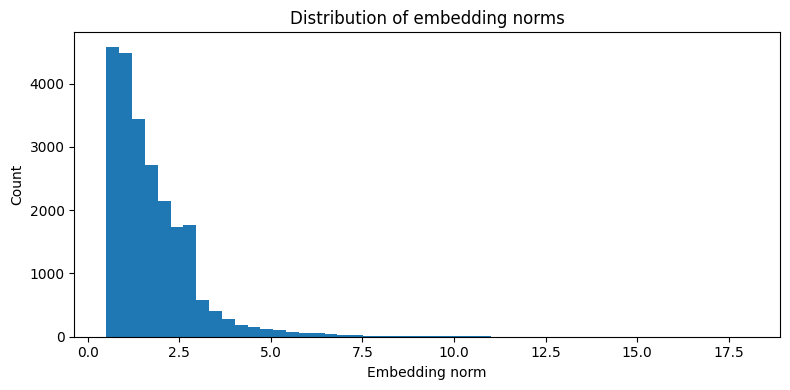

In [32]:
plt.figure(figsize=(8, 4))
plt.hist(df_emb["norm"], bins=50)
plt.xlabel("Embedding norm")
plt.ylabel("Count")
plt.title("Distribution of embedding norms")
plt.tight_layout()
plt.show()

## 5. Projeções 2D (PCA e t-SNE)

Usamos PCA para uma visualização rápida e, opcionalmente, t-SNE se o
`scikit-learn` estiver disponível. Para grafos muito grandes, fazemos subamostragem
no t-SNE para reduzir custo computacional.

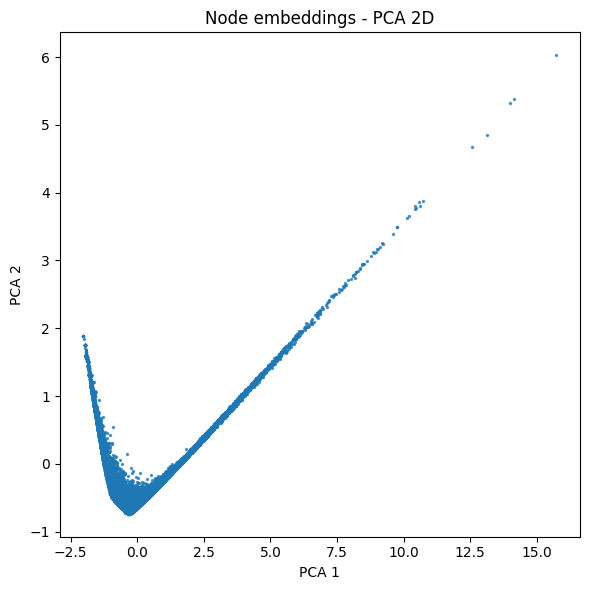

t-SNE em subamostra de 3000 nós (de 23133).


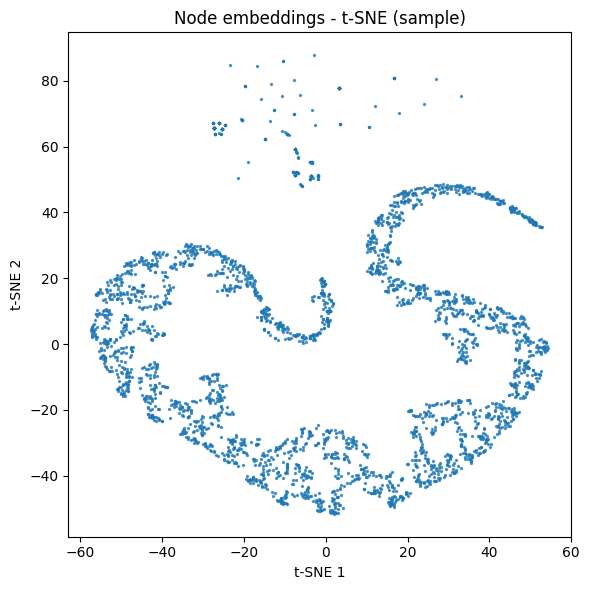

Embeddings + PCA salvos em: /workspace/results/06_node_embeddings_with_pca.csv


In [33]:
try:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    sklearn_available = True
except ImportError:
    print("scikit-learn não está disponível; pulando PCA/t-SNE.")
    sklearn_available = False

if sklearn_available:
    # PCA 2D
    pca = PCA(n_components=2, random_state=42)
    emb_pca = pca.fit_transform(emb_np)
    df_emb["pca_x"] = emb_pca[:, 0]
    df_emb["pca_y"] = emb_pca[:, 1]

    plt.figure(figsize=(6, 6))
    plt.scatter(df_emb["pca_x"], df_emb["pca_y"], s=2, alpha=0.7)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("Node embeddings - PCA 2D")
    plt.tight_layout()
    plt.show()

    # t-SNE (amostragem opcional)
    num_points = emb_np.shape[0]
    max_tsne_points = 3000
    if num_points > max_tsne_points:
        rng = np.random.default_rng(42)
        idx_sample = rng.choice(num_points, size=max_tsne_points, replace=False)
        emb_tsne_input = emb_np[idx_sample]
        print(f"t-SNE em subamostra de {max_tsne_points} nós (de {num_points}).")
    else:
        idx_sample = np.arange(num_points)
        emb_tsne_input = emb_np
        print(f"t-SNE em todos os {num_points} nós.")

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=42,
    )
    emb_tsne = tsne.fit_transform(emb_tsne_input)

    plt.figure(figsize=(6, 6))
    plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], s=2, alpha=0.7)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("Node embeddings - t-SNE (sample)")
    plt.tight_layout()
    plt.show()

    out_pca = RESULTS_DIR / "06_node_embeddings_with_pca.csv"
    df_emb.to_csv(out_pca, index=False)
    print("Embeddings + PCA salvos em:", out_pca)
else:
    print("Pulando PCA/t-SNE por falta de scikit-learn.")

## 6. Relação entre embeddings e grau dos nós

Comparamos a norma dos embeddings com o grau do nó no grafo original.

DataFrame combinado (embeddings + grau):


,node,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,norm,pca_x,pca_y,degree
0,0,0.000000,0.011541,0.039987,0.0,0.0,0.004841,0.000000,0.016014,0.052793,...,0.130510,0.13994,0.265133,0.000000,0.078003,0.115156,0.743526,-0.984703,-0.378202,3
1,1,0.667237,0.446466,0.000000,0.0,0.0,0.557961,0.618814,0.482417,0.625293,...,0.000000,0.00000,0.000000,0.493401,0.466978,0.000000,2.844969,1.773974,0.101348,8
2,2,0.231627,0.167816,0.000000,0.0,0.0,0.188937,0.225705,0.147563,0.229925,...,0.000000,0.00000,0.087550,0.194926,0.180895,0.000000,1.056392,0.100926,-0.584085,2
3,3,0.061759,0.055503,0.009762,0.0,0.0,0.055709,0.062112,0.042891,0.100044,...,0.063985,0.06827,0.198181,0.048773,0.106153,0.045916,0.566871,-0.640018,-0.579731,4
4,4,0.170389,0.125884,0.000000,0.0,0.0,0.142038,0.169558,0.110137,0.188199,...,0.000000,0.00000,0.134855,0.139565,0.165347,0.000000,0.840152,-0.126171,-0.650344,5


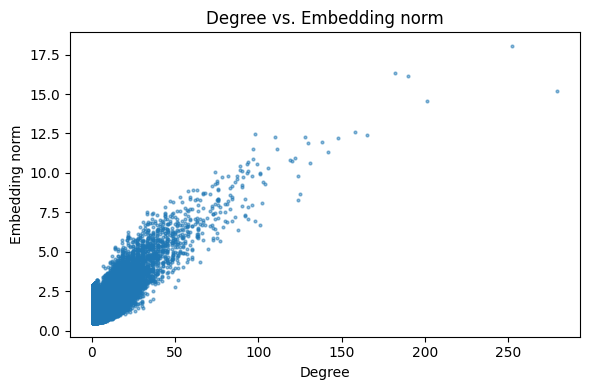

Embeddings + grau salvos em: /workspace/results/06_embeddings_with_degree.csv


In [34]:
# Degree no grafo completo
deg_dict = dict(G.degree())
df_deg = pd.DataFrame({
    "node": list(deg_dict.keys()),
    "degree": list(deg_dict.values()),
})

# Merge com embeddings via 'node'
df_merged = df_emb.merge(df_deg, on="node", how="left")

print("DataFrame combinado (embeddings + grau):")
display(df_merged.head())

plt.figure(figsize=(6, 4))
plt.scatter(df_merged["degree"], df_merged["norm"], s=4, alpha=0.5)
plt.xlabel("Degree")
plt.ylabel("Embedding norm")
plt.title("Degree vs. Embedding norm")
plt.tight_layout()
plt.show()

out_deg = RESULTS_DIR / "06_embeddings_with_degree.csv"
df_merged.to_csv(out_deg, index=False)
print("Embeddings + grau salvos em:", out_deg)

## 7. Mini experimento de link prediction via similaridade de embeddings

Selecionamos arestas reais (positivas) e pares não conectados (negativos),
e usamos a similaridade de cosseno entre embeddings como score. Avaliamos o
poder discriminativo via AUC, se `scikit-learn` estiver disponível.

AUC (link prediction via cosine similarity): 0.8120


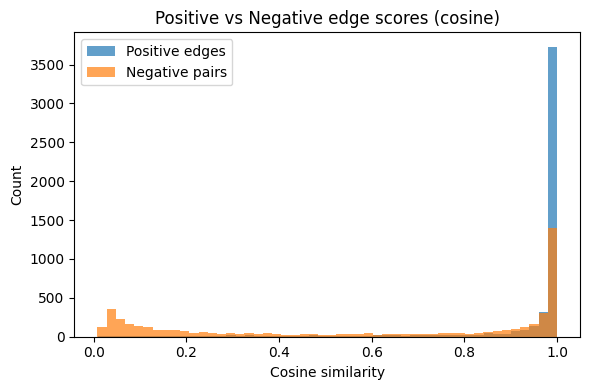

In [35]:
try:
    from sklearn.metrics import roc_auc_score
    sklearn_metrics_available = True
except ImportError:
    print("scikit-learn não está disponível; pulando experimento de link prediction.")
    sklearn_metrics_available = False

if sklearn_metrics_available:
    # Mapa node -> índice no array de embeddings
    node_to_idx = {n: i for i, n in enumerate(df_emb["node"].tolist())}

    # Normaliza embeddings na norma L2 (para cosseno)
    emb_norm = emb_np / (np.linalg.norm(emb_np, axis=1, keepdims=True) + 1e-9)

    # Amostragem de arestas positivas
    edges_list = list(G.edges())
    num_samples = min(5000, len(edges_list))
    rng = np.random.default_rng(42)
    pos_idx = rng.choice(len(edges_list), size=num_samples, replace=False)
    pos_pairs = [edges_list[i] for i in pos_idx]

    # Geração de pares negativos (não arestas)
    nodes_list = list(G.nodes())
    neg_pairs = []
    attempts = 0
    max_attempts = num_samples * 10
    while len(neg_pairs) < num_samples and attempts < max_attempts:
        u = rng.choice(nodes_list)
        v = rng.choice(nodes_list)
        if u == v:
            attempts += 1
            continue
        if G.has_edge(u, v):
            attempts += 1
            continue
        neg_pairs.append((u, v))
        attempts += 1

    def pair_cosine(u, v):
        if u not in node_to_idx or v not in node_to_idx:
            return 0.0
        iu = node_to_idx[u]
        iv = node_to_idx[v]
        return float(np.dot(emb_norm[iu], emb_norm[iv]))

    pos_scores = [pair_cosine(u, v) for (u, v) in pos_pairs]
    neg_scores = [pair_cosine(u, v) for (u, v) in neg_pairs]

    y_true = np.array([1] * len(pos_scores) + [0] * len(neg_scores))
    y_score = np.array(pos_scores + neg_scores)

    auc = roc_auc_score(y_true, y_score)
    print(f"AUC (link prediction via cosine similarity): {auc:.4f}")

    plt.figure(figsize=(6, 4))
    plt.hist(pos_scores, bins=50, alpha=0.7, label="Positive edges")
    plt.hist(neg_scores, bins=50, alpha=0.7, label="Negative pairs")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.title("Positive vs Negative edge scores (cosine)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Pulando experimento de link prediction por falta de scikit-learn.")

## 8. Resumo final dos experimentos

Consolidamos algumas métricas globais em um CSV de resumo para referência rápida
e uso em relatórios.

In [36]:
summary = {
    "num_nodes_graph": num_nodes,
    "num_edges_graph": num_edges,
    "density_graph": density,
    "is_connected": is_connected,
    "num_components": num_components,
    "lcc_size": size_lcc,
    "num_nodes_embeddings": num_nodes_emb,
    "embedding_dim": emb_dim,
}

df_summary = pd.DataFrame([summary])
out_summary = RESULTS_DIR / "06_embedding_experiments_summary.csv"
df_summary.to_csv(out_summary, index=False)
print("Resumo salvo em:", out_summary)
display(df_summary)

Resumo salvo em: /workspace/results/06_embedding_experiments_summary.csv


,num_nodes_graph,num_edges_graph,density_graph,is_connected,num_components,lcc_size,num_nodes_embeddings,embedding_dim
0,23133,93439,0.000349,False,567,21363,23133,64


In [37]:
print('Notebook 06 finished successfully. 🚀')

Notebook 06 finished successfully. 🚀
